Requirements

In [74]:
!pip install nibabel
!pip install scikit-image
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import s3fs
from pathlib import Path
import os
from tqdm import tqdm
from IPython.display import SVG, display
from skimage import measure
from scipy.stats import entropy

Connexion to S3

In [20]:
# Connexion to  MinIO S3 Onyxia

s3 = s3fs.S3FileSystem(
    client_kwargs={'endpoint_url': 'https://'+'minio.lab.sspcloud.fr'},
    key=os.getenv("AWS_ACCESS_KEY_ID"),
    secret=os.getenv("AWS_SECRET_ACCESS_KEY"),
    token=os.getenv("AWS_SESSION_TOKEN")
)

Download data

In [21]:
def download_s3_files(patient_id):
    num_id = patient_id[-3:]
    base_local_path = Path(f"/tmp/nnunet/{patient_id}")
    base_local_path.mkdir(parents=True, exist_ok=True)

    s3_paths = {
        "image": f"projet-statapp-segmedic/data/{patient_id}/image.nii.gz",
        "annotation": f"projet-statapp-segmedic/output/{patient_id}/ensemble_all/CURVAS_{num_id}.nii.gz",
        "softmax": f"projet-statapp-segmedic/output/{patient_id}/ensemble_all/CURVAS_{num_id}.npz"
    }

    print(f"\nTéléchargement des fichiers pour {patient_id}...")

    for key, s3_path in s3_paths.items():
        local_path = base_local_path / Path(s3_path).name
        try:
            print(f"→ {key}: {s3_path} → {local_path}")
            s3.get(s3_path, str(local_path))
        except Exception as e:
            print(f"Erreur lors du téléchargement de {s3_path}: {e}")

    print("\n✅ Téléchargement terminé.")

download_s3_files("UKCHLL003")



Téléchargement des fichiers pour UKCHLL003...
→ image: projet-statapp-segmedic/data/UKCHLL003/image.nii.gz → /tmp/nnunet/UKCHLL003/image.nii.gz
→ annotation: projet-statapp-segmedic/output/UKCHLL003/ensemble_all/CURVAS_003.nii.gz → /tmp/nnunet/UKCHLL003/CURVAS_003.nii.gz
→ softmax: projet-statapp-segmedic/output/UKCHLL003/ensemble_all/CURVAS_003.npz → /tmp/nnunet/UKCHLL003/CURVAS_003.npz

✅ Téléchargement terminé.


In [56]:
!ls /tmp/nnunet/UKCHLL003
!ls outputs/


CURVAS_003.nii.gz  CURVAS_003.npz  image.nii.gz
UKCHLL003_uncertainty_softmax.png  variance_milieu.png


Upload data

In [24]:
def upload_to_s3(local_folder, patient_id="UKCHLL003"):
    local_folder = Path(local_folder)
    s3_folder = f"projet-statapp-segmedic/uncertainty_map/{patient_id}"
    
    files = list(local_folder.rglob("*"))

    print(f"\nUpload des fichiers de {local_folder} vers {s3_folder}...")
    with tqdm(total=len(files), desc="Upload fichiers") as pbar:
        for file_path in files:
            if file_path.is_file():
                relative_path = file_path.relative_to(local_folder)
                s3_path = f"{s3_folder}/{relative_path.as_posix()}"
                try:
                    s3.put(str(file_path), s3_path)
                except Exception as e:
                    print(f"Erreur lors de l'upload de {file_path} → {s3_path}: {e}")
            pbar.update(1)

    print("\n✅ Upload terminé.")

Shape softmax original: (4, 866, 512, 512)
Shape image CT: (512, 512, 866)
Shape softmax après réorganisation: (512, 512, 866, 4)
Tranche médiane sélectionnée: 433 sur 866
Dimensions de la tranche CT: (512, 512)
Dimensions de la tranche de prédiction: (512, 512)

Upload des fichiers de outputs vers projet-statapp-segmedic/uncertainty_map/UKCHLL003...


Upload fichiers: 100%|██████████| 2/2 [00:00<00:00,  6.11it/s]


✅ Upload terminé.
Image sauvegardée localement sous outputs/UKCHLL003_uncertainty_softmax.png et uploadée vers S3


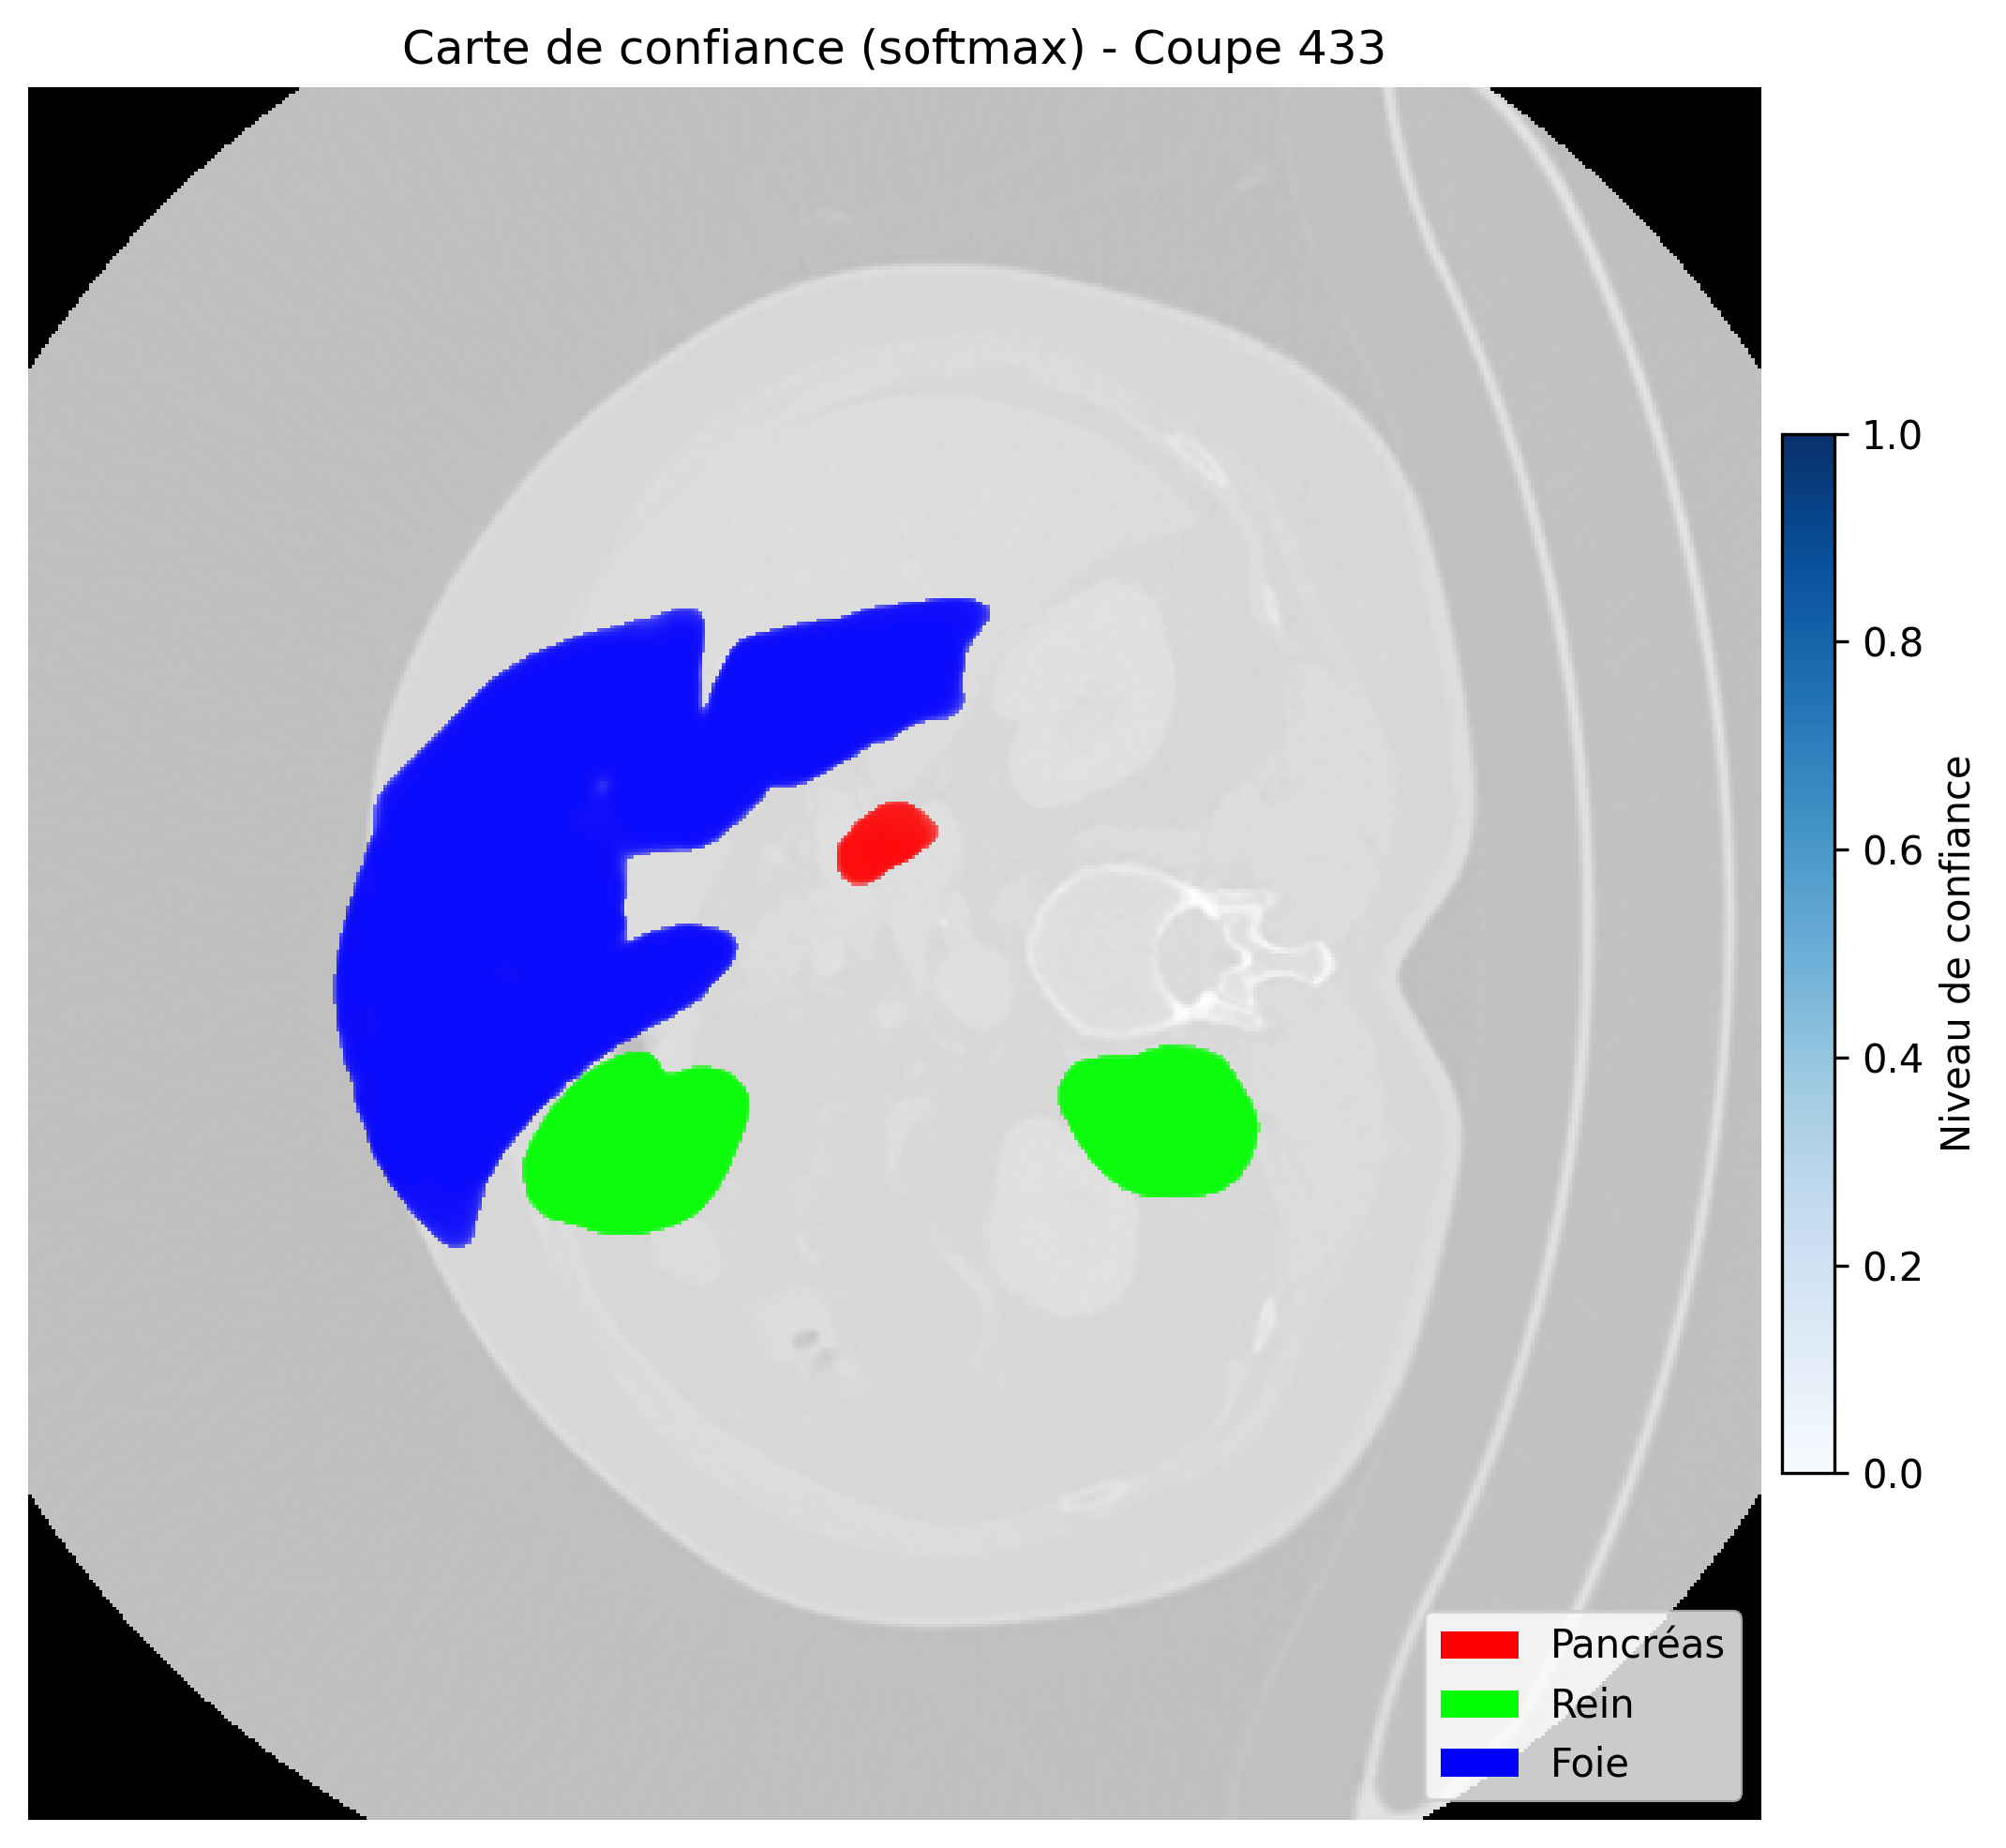

In [ ]:
def generate_uncertainty_map_from_softmax(softmax_npz_path, ct_path, output_filename="uncertainty_softmax_milieu.png"):
    """
    Génère une carte d'incertitude à partir des probabilités softmax et superpose
    avec une image CT. Le niveau de confiance est visualisé par un gradient de transparence
    (plus la confiance est élevée, moins la segmentation est transparente).
    
    Args:
        softmax_npz_path: Chemin vers le fichier NPZ contenant les probabilités softmax
        ct_path: Chemin vers l'image CT (format NIfTI)
        output_filename: Nom du fichier de sortie
    """
    
    
    # Charger les probabilités softmax
    data = np.load(softmax_npz_path)
    softmax = data['probabilities']  # shape initiale: (C, H, W, D)
    if softmax.shape[0] != 4:
        raise ValueError("Le softmax doit contenir 4 classes (background, pancréas, rein, foie).")
    
    print("Shape softmax original:", softmax.shape)
    
    # Charger l'image CT
    ct_img = nib.load(ct_path).get_fdata()
    print("Shape image CT:", ct_img.shape)  # (512, 512, 866)
    
    # Réorganiser les dimensions du softmax pour correspondre à l'image CT
    # Si softmax est (4, 866, 512, 512), le réorganiser en (512, 512, 866, 4)
    # pour correspondre à la structure (X, Y, Z, C) où X, Y, Z sont les dimensions spatiales
    if softmax.shape[1:] == (ct_img.shape[2], ct_img.shape[0], ct_img.shape[1]):
        # Si le softmax est (C, D, H, W) et CT est (H, W, D)
        softmax = np.transpose(softmax, (2, 3, 1, 0))
    elif softmax.shape[1:] == (ct_img.shape[0], ct_img.shape[1], ct_img.shape[2]):
        # Si le softmax est (C, H, W, D) et CT est (H, W, D)
        softmax = np.moveaxis(softmax, 0, -1)
    else:
        raise ValueError(f"Dimensions incompatibles: softmax {softmax.shape} vs CT {ct_img.shape}")
    
    print("Shape softmax après réorganisation:", softmax.shape)
    
    # Calcul de la prédiction (classe) et de la confiance
    pred = np.argmax(softmax, axis=-1)        # shape: (X, Y, Z)
    confidence = np.max(softmax, axis=-1)     # shape: (X, Y, Z)
    
    # Prendre la tranche axiale médiane
    z_median = ct_img.shape[2] // 2
    ct_slice = ct_img[:, :, z_median]
    pred_slice = pred[:, :, z_median]
    conf_slice = confidence[:, :, z_median]
    
    print(f"Tranche médiane sélectionnée: {z_median} sur {ct_img.shape[2]}")
    print(f"Dimensions de la tranche CT: {ct_slice.shape}")
    print(f"Dimensions de la tranche de prédiction: {pred_slice.shape}")
    
    # Créer image RGBA (H, W, 4)
    rgba = np.zeros((*pred_slice.shape, 4), dtype=np.float32)
    
    # Normaliser l'image CT pour l'affichage
    ct_norm = (ct_slice - ct_slice.min()) / (ct_slice.max() - ct_slice.min())
    
    # Couleurs (R, G, B) pour chaque classe
    color_map = {
        1: (1.0, 0.0, 0.0),  # Pancréas - rouge
        2: (0.0, 1.0, 0.0),  # Rein - vert
        3: (0.0, 0.0, 1.0)   # Foie - bleu
    }
    
    # Niveau de confiance minimum pour la visibilité
    min_confidence = 0.01
    
    # Créer un gradient de transparence basé sur la confiance
    # Background reste transparent (classe 0)
    for label, (r, g, b) in color_map.items():
        mask = pred_slice == label
        
        if np.any(mask):  # Vérifier si la classe est présente
            # Extraction des valeurs de confiance pour cette classe
            conf_values = conf_slice[mask]
            
            # Appliquer les couleurs
            rgba[mask, 0] = r
            rgba[mask, 1] = g
            rgba[mask, 2] = b
            
            # Créer un véritable gradient de transparence:
            # - Confiance minimale -> transparence élevée (alpha faible)
            # - Confiance maximale -> opaque (alpha élevé)
            
            # Remap la confiance entre min_alpha et 1.0
            min_alpha = 0.05  # Transparence minimale
            max_alpha = 0.95  # Transparence maximale
            
            # Normaliser dans la plage [min_alpha, max_alpha] pour meilleure visibilité
            alpha_values = min_alpha + (conf_values * (max_alpha - min_alpha))
            
            # Assigner les valeurs alpha
            rgba[mask, 3] = alpha_values
    
    
    # Affichage
    # Afficher l'image CT en niveaux de gris
    plt.figure(figsize=(10, 8))
    plt.imshow(ct_norm, cmap='gray')
    
    # Superposer la segmentation colorée avec transparence basée sur la confiance
    plt.imshow(rgba)
    
    # Ajouter une légende pour les classes
    from matplotlib.patches import Patch
    from matplotlib.colors import LinearSegmentedColormap
    import matplotlib.cm as cm
    
    # Légende pour les classes
    legend_elements = [
        Patch(facecolor=color_map[1], label='Pancréas'),
        Patch(facecolor=color_map[2], label='Rein'),
        Patch(facecolor=color_map[3], label='Foie')
    ]
    
    # Ajouter une colorbar pour montrer le niveau de confiance
    ax = plt.gca()
    cmap = cm.Blues
    norm = plt.Normalize(0, 1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.01, shrink=0.6)
    cbar.set_label('Niveau de confiance')
    
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.title(f"Carte de confiance (softmax) - Coupe {z_median}")
    plt.axis('off')
    
    # Créer le dossier de sortie si nécessaire
    os.makedirs("outputs", exist_ok=True)
    local_path = os.path.join("outputs", output_filename)
    
    # Sauvegarder l'image
    plt.savefig(local_path, bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.close()
    
    # Upload vers S3
    upload_to_s3("outputs", patient_id=output_filename.split('_')[0])
    print(f"Image sauvegardée localement sous {local_path} et uploadée vers S3")
    

generate_uncertainty_map_from_softmax(
    softmax_npz_path="/tmp/nnunet/UKCHLL003/CURVAS_003.npz",
    ct_path="/tmp/nnunet/UKCHLL003/image.nii.gz",
    output_filename="UKCHLL003_uncertainty_softmax.png"
)

# Afficher l'image résultante
display(Image(filename="outputs/UKCHLL003_uncertainty_softmax.png"))


Upload des fichiers de outputs vers projet-statapp-segmedic/uncertainty_map/UKCHLL003...


Upload fichiers: 100%|██████████| 3/3 [00:00<00:00,  9.90it/s]



✅ Upload terminé.
Image sauvegardée sous outputs/UKCHLL003_uncertainty_entropy_heatmap.png


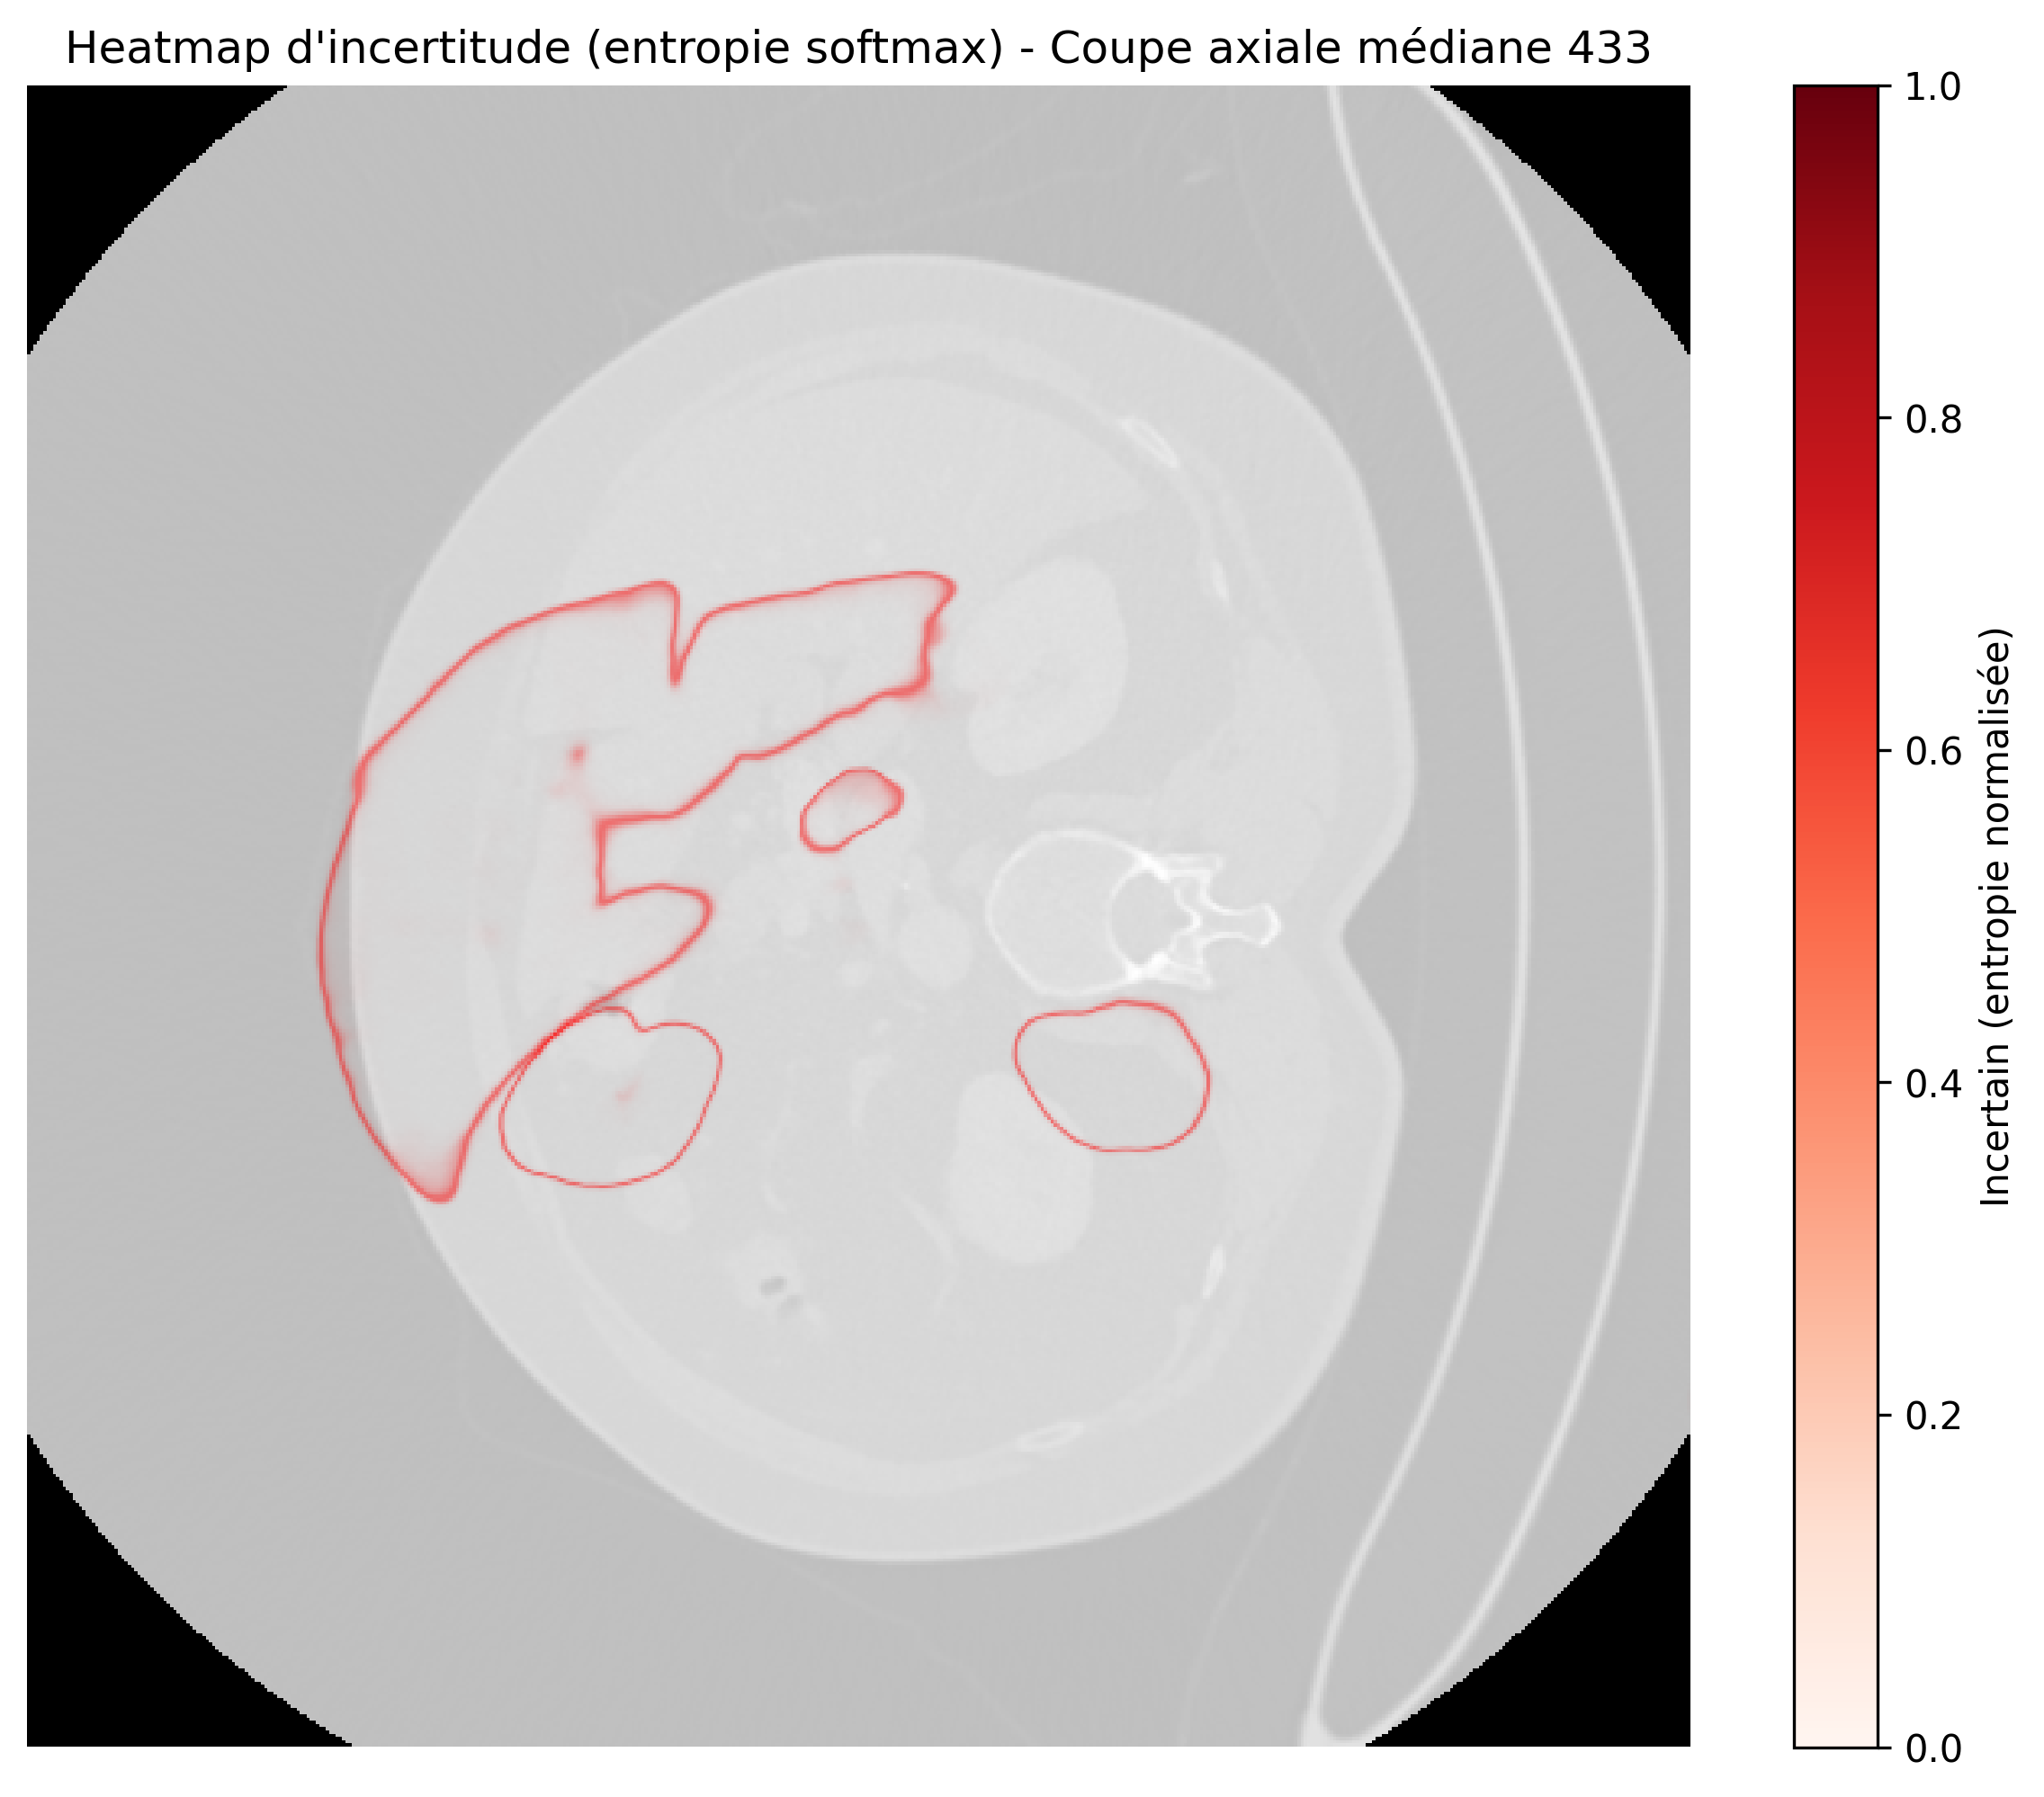

In [62]:
def generate_uncertainty_heatmap_from_softmax(softmax_npz_path, ct_path, output_filename="uncertainty_entropy_heatmap.png"):
    """
    Génère une carte d'incertitude à partir des probabilités softmax via l'entropie, superposée à l'image CT.
    
    Args:
        softmax_npz_path: chemin vers fichier NPZ avec softmax 'probabilities' (4 classes)
        ct_path: chemin vers image CT NIfTI
        output_filename: nom du fichier image sauvegardé
    """
    # Charger softmax
    data = np.load(softmax_npz_path)
    softmax = data['probabilities']  # (C, H, W, D) ou similaire
    if softmax.shape[0] != 4:
        raise ValueError("Softmax doit avoir 4 classes.")
    
    # Charger CT
    ct_img = nib.load(ct_path).get_fdata()
    
    # Réorganiser softmax pour correspondre à CT (H, W, D, 4)
    if softmax.shape[1:] == (ct_img.shape[2], ct_img.shape[0], ct_img.shape[1]):
        softmax = np.transpose(softmax, (2, 3, 1, 0))
    elif softmax.shape[1:] == (ct_img.shape[0], ct_img.shape[1], ct_img.shape[2]):
        softmax = np.moveaxis(softmax, 0, -1)
    else:
        raise ValueError(f"Dimensions incompatibles : softmax {softmax.shape} vs CT {ct_img.shape}")
    
    # Calculer l'entropie voxel par voxel
    epsilon = 1e-10  # éviter log(0)
    entropy = -np.sum(softmax * np.log(softmax + epsilon), axis=-1)  # (H, W, D)
    
    # Normaliser entropie [0, max_entropy]
    max_entropy = np.log(4)  # car 4 classes max
    entropy_norm = entropy / max_entropy  # entre 0 et 1
    
    # Extraire tranche axiale médiane
    z_mid = ct_img.shape[2] // 2
    ct_slice = ct_img[:, :, z_mid]
    entropy_slice = entropy_norm[:, :, z_mid]
    
    # Normaliser CT pour affichage
    ct_norm = (ct_slice - ct_slice.min()) / (ct_slice.max() - ct_slice.min())
    
    # Créer image RGBA pour heatmap rouge (incertitude)
    rgba = np.zeros((*entropy_slice.shape, 4), dtype=np.float32)
    rgba[..., 0] = 1.0  # rouge
    rgba[..., 3] = entropy_slice  # alpha = incertitude normalisée
    
    # Affichage
    plt.figure(figsize=(10, 8))
    plt.imshow(ct_norm, cmap='gray')
    plt.imshow(rgba, cmap='Reds', alpha=entropy_slice)
    plt.colorbar(label='Incertain (entropie normalisée)')
    plt.title(f"Heatmap d'incertitude (entropie softmax) - Coupe axiale médiane {z_mid}")
    plt.axis('off')
    
    # Sauvegarder
    os.makedirs("outputs", exist_ok=True)
    local_path = os.path.join("outputs", output_filename)
    plt.savefig(local_path, bbox_inches='tight', dpi=300)
    plt.close()
    upload_to_s3("outputs", patient_id=output_filename.split('_')[0])
    
    print(f"Image sauvegardée sous {local_path}")


generate_uncertainty_heatmap_from_softmax(
    softmax_npz_path="/tmp/nnunet/UKCHLL003/CURVAS_003.npz",
    ct_path="/tmp/nnunet/UKCHLL003/image.nii.gz",
    output_filename="UKCHLL003_uncertainty_entropy_heatmap.png"
)

# Afficher l'image résultante
display(Image(filename="outputs/UKCHLL003_uncertainty_entropy_heatmap.png"))


Shape softmax original: (4, 866, 512, 512)
Shape image CT: (512, 512, 866)
Shape softmax après réorganisation: (512, 512, 866, 4)
Tranche médiane sélectionnée: 433 sur 866
Image sauvegardée localement sous outputs/UKCHLL003_uncertainty_entropy.svg

Upload des fichiers de outputs vers projet-statapp-segmedic/uncertainty_map/UKCHLL003...


Upload fichiers: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]



✅ Upload terminé.
Image uploadée vers S3


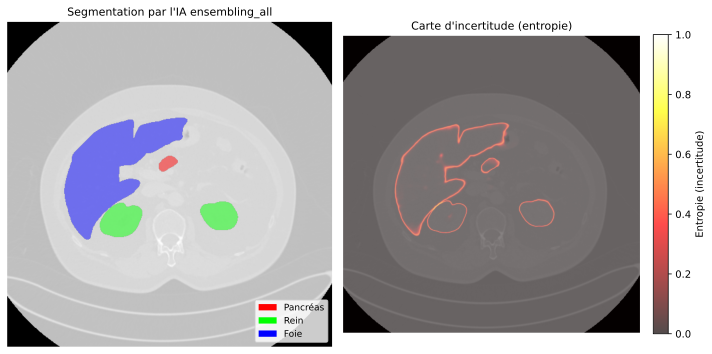

In [77]:
def generate_uncertainty_maps(softmax_npz_path, ct_path, output_filename="uncertainty_comparison.png"):
    """
    Génère côte à côte:
    1. Une carte d'incertitude basée sur l'entropie des probabilités softmax
    2. Une visualisation des organes segmentés avec contours colorés
    
    L'entropie est une mesure d'incertitude: plus l'entropie est élevée, 
    plus la distribution des probabilités est uniforme, indiquant une incertitude élevée.
    
    Args:
        softmax_npz_path: Chemin vers le fichier NPZ contenant les probabilités softmax
        ct_path: Chemin vers l'image CT (format NIfTI)
        output_filename: Nom du fichier de sortie
    """
    # Charger les probabilités softmax
    data = np.load(softmax_npz_path)
    softmax = data['probabilities']  # shape initiale: (C, H, W, D)
    if softmax.shape[0] != 4:
        raise ValueError("Le softmax doit contenir 4 classes (background, pancréas, rein, foie).")
    
    print("Shape softmax original:", softmax.shape)
    
    # Charger l'image CT
    ct_img = nib.load(ct_path).get_fdata()
    print("Shape image CT:", ct_img.shape)  # (512, 512, 866)
    
    # Réorganiser les dimensions du softmax pour correspondre à l'image CT
    if softmax.shape[1:] == (ct_img.shape[2], ct_img.shape[0], ct_img.shape[1]):
        # Si le softmax est (C, D, H, W) et CT est (H, W, D)
        softmax = np.transpose(softmax, (2, 3, 1, 0))
    elif softmax.shape[1:] == (ct_img.shape[0], ct_img.shape[1], ct_img.shape[2]):
        # Si le softmax est (C, H, W, D) et CT est (H, W, D)
        softmax = np.moveaxis(softmax, 0, -1)
    else:
        raise ValueError(f"Dimensions incompatibles: softmax {softmax.shape} vs CT {ct_img.shape}")
    
    print("Shape softmax après réorganisation:", softmax.shape)
    
    # Tranche médiane axiale
    z_median = ct_img.shape[2] // 2
    ct_slice = ct_img[:, :, z_median].T
    softmax_slice = softmax[:, :, z_median, :]  # shape (H, W, 4)
    
    print(f"Tranche médiane sélectionnée: {z_median} sur {ct_img.shape[2]}")
    
    # Calculs principaux:
    # 1. Calcul de l'entropie (mesure d'incertitude)
    # L'entropie est élevée quand la distribution est uniforme (incertitude maximale)
    entropy_map = entropy(softmax_slice, axis=-1)
    # Normaliser l'entropie entre 0 et 1 pour l'affichage
    entropy_norm = entropy_map / np.log(softmax.shape[-1])  # Division par log(nb_classes) pour normaliser
    
    # 2. Prédiction et confiance
    pred_slice = np.argmax(softmax_slice, axis=-1)
    conf_slice = np.max(softmax_slice, axis=-1)
    
    # Normaliser CT pour l'affichage
    ct_norm = (ct_slice - ct_slice.min()) / (ct_slice.max() - ct_slice.min())
    
    # Palette de couleurs pour les organes
    color_map = {
        1: (1.0, 0.0, 0.0),  # Pancréas - rouge
        2: (0.0, 1.0, 0.0),  # Rein - vert
        3: (0.0, 0.0, 1.0)   # Foie - bleu
    }
    
    # Création de l'image CT avec superposition d'entropie
    # L'entropie élevée = incertitude élevée (rouge)
    rgba_entropy = np.zeros((*entropy_norm.shape, 4), dtype=np.float32)
    # Rouge pour l'incertitude (mode "hot")
    rgba_entropy[..., 0] = entropy_norm  # Rouge proportionnel à l'entropie
    rgba_entropy[..., 3] = np.clip(entropy_norm * 1.2, 0.0, 0.8)  # Alpha plus élevé où l'entropie est forte
    
    # Création des contours des organes sur fond CT
    ct_rgb = np.stack([ct_norm]*3, axis=-1)  # convertir en RGB
    overlay_contours = ct_rgb.copy()
    
    # Création de la carte de segmentation (remplissage + contours)
    # Option 1: Contours fins
    for label, (r, g, b) in color_map.items():
        mask = pred_slice == label
        contours = measure.find_contours(mask.astype(np.uint8), 0.5)
        for contour in contours:
            contour = contour.astype(int)
            # Tracer contours en couleur sur l'overlay (bordures de 1 pixel)
            for y, x in contour:
                if 0 <= y < overlay_contours.shape[0] and 0 <= x < overlay_contours.shape[1]:
                    overlay_contours[y, x] = [r, g, b]
    
    # Option 2: Segmentation semi-transparente avec remplissage
    rgba_seg = np.zeros((*pred_slice.shape, 4), dtype=np.float32)
    for label, (r, g, b) in color_map.items():
        mask = pred_slice == label
        rgba_seg[mask, 0] = r
        rgba_seg[mask, 1] = g
        rgba_seg[mask, 2] = b
        rgba_seg[mask, 3] = 0.5  # Transparence constante
    
    # Création de la figure 2×2
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    
    # Aplatir le tableau des axes pour faciliter l'itération
    axes = axes.flatten()
    
    # Image 1: Carte incertitude (entropie)
    axes[1].imshow(ct_norm, cmap='gray')
    im2 = axes[1].imshow(entropy_norm, cmap='hot', alpha=0.7, vmin=0, vmax=1)
    axes[1].set_title("Carte d'incertitude (entropie)", fontsize=11)
    axes[1].axis('off')
    cbar = plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    cbar.set_label('Entropie (incertitude)', fontsize=10)
    
    # Image 2: Segmentation faite par le réseau de neurones
    axes[0].imshow(ct_norm, cmap='gray')
    axes[0].imshow(rgba_seg)
    axes[0].set_title("Segmentation par l'IA ensembling_all", fontsize=11)
    axes[0].axis('off')
    
    # Ajouter légende pour les organes sur les deux images de segmentation
    legend_elements = [
        Patch(facecolor=color_map[1], label='Pancréas'),
        Patch(facecolor=color_map[2], label='Rein'),
        Patch(facecolor=color_map[3], label='Foie')
    ]
    axes[0].legend(handles=legend_elements, loc='lower right', fontsize=9)

    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')

    # Titre global
    #plt.suptitle(f"Analyse de segmentation - Coupe {z_median}/{ct_img.shape[1]}", fontsize=14)
    plt.tight_layout()
    
    # Créer le dossier de sortie si nécessaire
    os.makedirs("outputs", exist_ok=True)
    local_path = os.path.join("outputs", output_filename)
    
    # Sauvegarder l'image
    plt.savefig(local_path, bbox_inches='tight', dpi=300)
    plt.close()
    
    print(f"Image sauvegardée localement sous {local_path}")
    
    # Upload vers S3
    try:
        upload_to_s3("outputs", patient_id=output_filename.split('_')[0])
        print(f"Image uploadée vers S3")
    except Exception as e:
        print(f"Erreur lors de l'upload S3: {e}")
    
    # Afficher l'image
    return local_path

# Exemple d'utilisation
if __name__ == "__main__":
    output_path = generate_uncertainty_maps(
        softmax_npz_path="/tmp/nnunet/UKCHLL003/CURVAS_003.npz",
        ct_path="/tmp/nnunet/UKCHLL003/image.nii.gz",
        output_filename="UKCHLL003_uncertainty_entropy.svg"
    )
    
    # Afficher l'image résultante
    display(SVG(filename=output_path))